In [9]:
"""
Estimation
First-Order Differential Equation Estimation with Time Delay  - Tclab

@author: Jeferson Gallego Chaverra
        Pedro Alejandro Sanchez Osorio
        Victor Alfonso Echeverri Moyano
"""


import numpy as np
import matplotlib.pyplot as plt
import control as cl
import math as ma
import sympy as sym
from scipy.integrate import *
from scipy.optimize import *
from sklearn.metrics import *
from Funtions import *

# Derivative First Order Delay Transfer Function
def fopdt(t,y,uf,Km,taum,thetam):
    # Arguments
    # y       = Output
    # t       = Time
    # uf      = Linear input function (To do time shifting)
    # Km      = Gain
    # taum    = Time Constant
    # thetam  = Delay

    try:
        if (t-thetam) <= 0:      
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        um = u0
    # Return : Output Equation = Derivative Calculation
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# # Simulation System 
def sim_model(x):
    # Arguments IN
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # Vector Out
    ym = np.ones(ns) * yp0  # Initial Conditión
    y0 = [yp0]              # Initial Y(t)
    # Model Simulation (Integration)  
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        sol = solve_ivp(fopdt,ts, y0,args=(uf,Km,taum,thetam))
        y0 = sol.y[:, -1]
        ym[i+1] = y0[0]
    return ym

name = "FT_Prbs_%_Step"

# Funtion Objetive
def objective(x):
    # Calculate Cost
    obj = 0.0
    # Model Simulation
    ym = sim_model(x)
    for i in range(len(ym)):
        obj = obj + ((yp[i] - ym[i]) / yp[i]) ** 2
        
    return obj


## Estimation
## First-Order Differential Equation + Time Delay  (FODE)

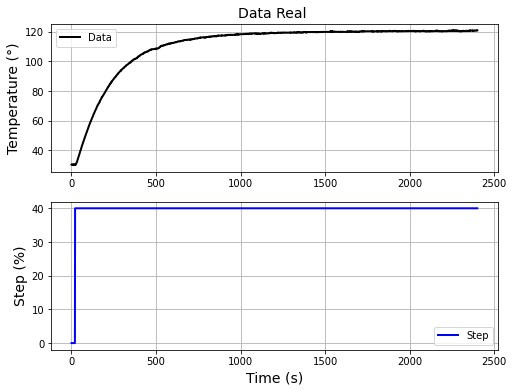

In [10]:
# Upload Data 
x =limites('DATA 1 OR 3 ?',1,3)

# Data
if x==1:
     data = np.loadtxt('1.txt',delimiter=',',skiprows=1)
elif x == 2:
     data = np.loadtxt('2.txt',delimiter=',',skiprows=1)
elif x == 3:
     data = np.loadtxt('3.txt',delimiter=',',skiprows=1)


# Ininitial IN y OUT 
u0 = data[0,1]
yp0 = data[0,2]

# Experimental Data
t = data[:,0].T - data[0,0]
u = data[:,1].T
yp = data[:,2].T

# Iterations
ns = len(t)

# Linear interpolation of time with u (useful to involve the delay)
uf = interp1d(t,u)

# Initial Estimate
K = 2
tau = 200
theta = 0.2

x0 = np.zeros(3)
x0[0] = K # Km
x0[1] = tau # taum
x0[2] = theta # thetam

# Graph
plt.figure(figsize=(8,6))

# Subplot Data
ax=plt.subplot(2,1,1)
ax.grid()
plt.title("Data Real ",fontsize = 14)
plt.plot(t, yp, 'k', linewidth=2, label='Data')
plt.ylabel('Temperature (°)', fontsize = 14)
plt.legend(loc='best')

# Subplot Step          
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(t, u, 'b-', linewidth=2, label='Step')
plt.ylabel('Step (%)', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 14)
plt.legend(loc='best')

plt.show()

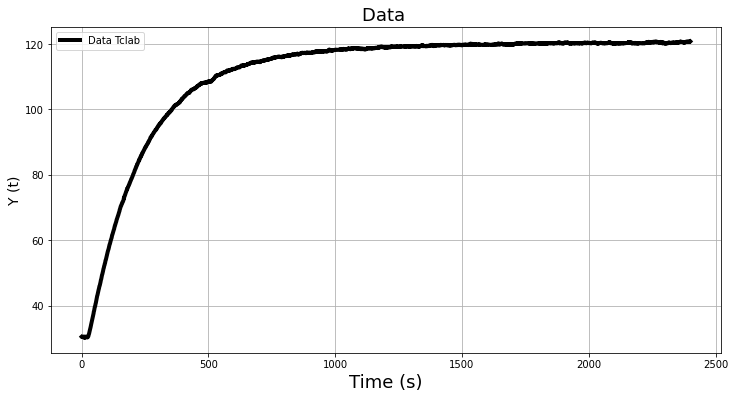

In [11]:
# DATA   
plt.figure(figsize=(12,6))
plt.title("Data ",fontsize = 18)
plt.plot(t, yp, 'k', linewidth=4, label='Data Tclab')
plt.ylabel('Y (t)', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 18)
plt.legend(loc='best')
plt.grid()

In [12]:
# OPTIMIZATION
print(f"Initial SEE: {objective(x0)}")


solution= minimize(objective,x0,method='SLSQP')
x=solution.x
print(solution.message)
print(f'Final SSE: {objective(x)}')

Initial SEE: 11.39815617640593
Optimization terminated successfully
Final SSE: 0.06114101007186683


In [13]:
# Graph y Evaluation

y = sim_model(x0)
ye = sim_model(x)

#x = list(x0)
print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

Kc = x[0]
Tau = x[1]
Theta =  x[2]

Kp: 2.231500521091456
taup: 218.5098910421281
thetap: 7.092706471075107


G(s) =     
   2.232
-----------
218.5 s + 1

e^  - 7.0927
Mean Squared Error              =  0.3037
Root Mean Squared Error         =  0.5511
Mean Absolute Error             =  0.4738
Mean Absolute Percentage Error  =  0.0043
R2                              =  0.9992
MAX Error                       =  1.4616


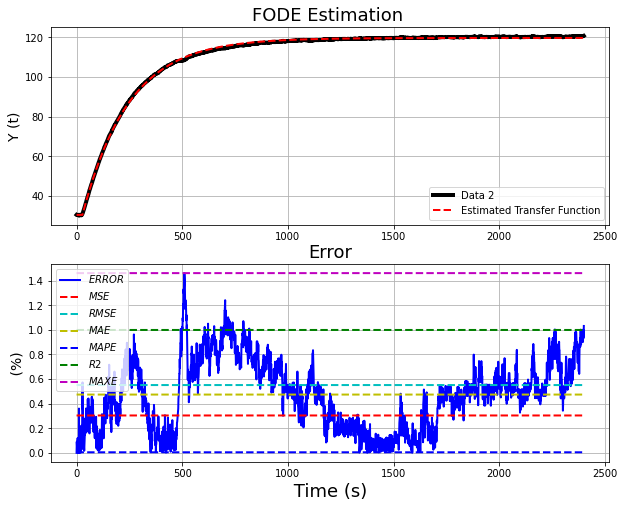

In [14]:
# Approximate Transfer Function:
Ge = cl.tf([Kc],[Tau,1])

# Error
e = np.abs(yp[0:len(ye)] - ye[0:len(ye)])

# Evaluation Criteria 
MSE = mean_squared_error(yp[0:len(ye)], ye[0:len(ye)])
RMSE=ma.sqrt(MSE)
MAE = mean_absolute_error(yp[0:len(ye)], ye[0:len(ye)])
MAPE = mean_absolute_percentage_error(yp[0:len(ye)], ye[0:len(ye)])
R2 = r2_score(yp[0:len(ye)], ye[0:len(ye)])
MAXE = max_error(yp[0:len(ye)], ye[0:len(ye)])

# Print
print(f"G(s) =     {Ge}") 
print(f"e^  - {Theta:.4f}")
print(f"Mean Squared Error              =  {MSE:.4f}")
print(f"Root Mean Squared Error         =  {RMSE:.4f}")
print(f"Mean Absolute Error             =  {MAE:.4f}")
print(f"Mean Absolute Percentage Error  =  {MAPE:.4f}")
print(f"R2                              =  {R2:.4f}")
print(f"MAX Error                       =  {MAXE:.4f}")

# Graph
mse = np.ones(int(len(t)))*MSE 
rmse = np.ones(int(len(t)))*RMSE
mae = np.ones(int(len(t)))*MAE 
mape = np.ones(int(len(t)))*MAPE 
r2 = np.ones(int(len(t)))*R2 
maxe = np.ones(int(len(t)))*MAXE 

# Plot
plt.figure(figsize=(10,8))

ax=plt.subplot(2,1,1)
ax.grid()
plt.title("FODE Estimation ",fontsize = 18)
plt.plot(t, yp, 'k', linewidth=4, label='Data  ') # Datos del Proceso
plt.plot(t, ye, 'r--', linewidth=2, label='Estimated Transfer Function') # FT POR Optimizada
plt.ylabel('Y (t)', fontsize = 14)
plt.legend(loc='best')

ax=plt.subplot(2,1,2)
ax.grid()
plt.title("Error",fontsize = 18)
plt.plot(t[0:len(ye)],e[0:len(ye)],  'b-'  , linewidth=2, label=r'$ERROR$')
plt.plot(t[0:len(ye)],mse[0:len(ye)],  'r--'  , linewidth=2, label=r'$MSE$')
plt.plot(t[0:len(ye)],rmse[0:len(ye)],  'c--'  , linewidth=2, label=r'$RMSE$')
plt.plot(t[0:len(ye)],mae[0:len(ye)],  'y--'  , linewidth=2, label=r'$MAE$')
plt.plot(t[0:len(ye)],mape[0:len(ye)],  'b--'  , linewidth=2, label=r'$MAPE$')
plt.plot(t[0:len(ye)],r2[0:len(ye)],  'g--'  , linewidth=2, label=r'$R2$')
plt.plot(t[0:len(ye)],maxe[0:len(ye)],  'm--'  , linewidth=2, label=r'$MAXE$')
plt.ylabel(' (%) ', fontsize = 14)
plt.xlabel(' Time (s) ', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [15]:
"""

https://www.statdeveloper.com/evaluacion-del-modelo-de-regresion/

Data 1: 20 % Step

Ge =     
   2.257
-----------
232.8 s + 1

e^  - 3.5316
Mean Squared Error              =  0.3387
Root Mean Squared Error         =  0.5820
Mean Absolute Error             =  0.4814
Mean Absolute Percentage Error  =  0.0065
R2                              =  0.9977
MAX Error                       =  1.8927

-------------------------------------------------------------------------------------------------------
Data 2: 40 % Step

Ge =     
   2.232
-----------
218.5 s + 1

e^  - 7.0927
Mean Squared Error              =  0.3037
Root Mean Squared Error         =  0.5511
Mean Absolute Error             =  0.4738
Mean Absolute Percentage Error  =  0.0043
R2                              =  0.9992
MAX Error                       =  1.4616

-----------------------------------------------------------------------------------------------------
Data 3 = Steps Mulltiples
Ge =     
   2.221
-----------
218.3 s + 1

e^  - 2.1078
Mean Squared Error              =  1.4029
Root Mean Squared Error         =  1.1844
Mean Absolute Error             =  0.9470
Mean Absolute Percentage Error  =  0.0113
R2                              =  0.9975
MAX Error                       =  3.6158

"""

'\n\nhttps://www.statdeveloper.com/evaluacion-del-modelo-de-regresion/\n\nData 1: 20 % Step\n\nGe =     \n   2.257\n-----------\n232.8 s + 1\n\ne^  - 3.5316\nMean Squared Error              =  0.3387\nRoot Mean Squared Error         =  0.5820\nMean Absolute Error             =  0.4814\nMean Absolute Percentage Error  =  0.0065\nR2                              =  0.9977\nMAX Error                       =  1.8927\n\n-------------------------------------------------------------------------------------------------------\nData 2: 40 % Step\n\nGe =     \n   2.232\n-----------\n218.5 s + 1\n\ne^  - 7.0927\nMean Squared Error              =  0.3037\nRoot Mean Squared Error         =  0.5511\nMean Absolute Error             =  0.4738\nMean Absolute Percentage Error  =  0.0043\nR2                              =  0.9992\nMAX Error                       =  1.4616\n\n-----------------------------------------------------------------------------------------------------\nData 3 = Steps Mulltiples\nGe 